# Denpendencies

In [ ]:
import keras
from keras.datasets import mnist
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import sys
import copy
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# Preparing dataset

In [ ]:
# just load a simple benchmark dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

11490434/11490434 [==============================] - 2s 0us/step


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


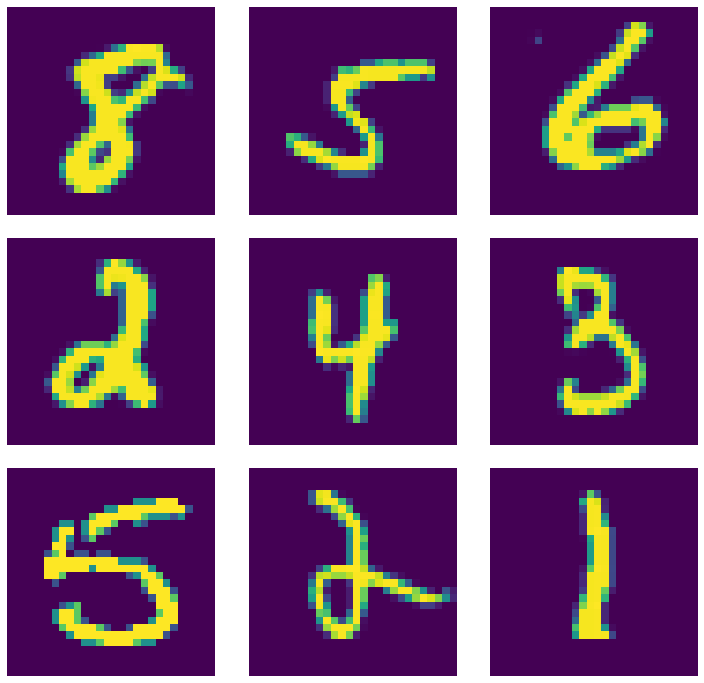

In [ ]:
plt.figure(figsize=(10, 10))
train_images_list = list(ds_train)[0][0]
#train_labels_list = list(ds_train)[0][1]
for n in range(9):
    i = np.random.randint(0, len(train_images_list), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.tight_layout()
    plt.imshow(train_images_list[i[0]])
    #plt.title('Label: ' + str(train_labels_list[i[0]]))
    plt.axis('off')

# Build network class

In [ ]:
# use the most simple structured neural network of densely connected architechture
class NeuralFitness:
    def __init__(self, TRAIT_LIST):
        self.neuron_list = TRAIT_LIST[:5]
        self.lr = TRAIT_LIST[-1]
        self.is_live = self.build_frankenstein()
        #self.fitness = self.get_fitness()
    
    def build_frankenstein(self):
        if 0 == sum([int(i) for i in self.neuron_list]):
            return False

        self.model = self.get_initial_network()

        for neuron in self.neuron_list:
            if 0 == int(neuron):
                continue
            self.add_layer(neuron, 'relu')

        self.add_layer(10, 'softmax')
        #print(self.model.summary())
        self.compile_model()
        return True
    
    def print_network_summary(self):
        if False == self.is_live:
            print("DEAD")
            return
        print(self.model.summary())

    def get_initial_network(self):
        return keras.Sequential([
            keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
        ])
    
    def add_layer(self, UNITS, ACTIVATION):
        self.model.add(keras.layers.Dense(units=int(UNITS), activation=ACTIVATION))
    
    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = self.lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
    
    def get_fitness(self):
        if False == self.is_live:
            return 0
        
        callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=3,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=False
        )

        self.history = self.model.fit(
            ds_train,
            epochs=5,
            verbose=0,
            validation_data=ds_test,
            callbacks=[callback]
        )

        evaluation = self.model.evaluate(ds_test, return_dict=True, verbose=0)
        fitness = evaluation['sparse_categorical_accuracy']
        return fitness

trait_list = ['64', '512', 0, 0, 0, 0.01]
nf = NeuralFitness(trait_list)
nf.print_network_summary()
print(nf.get_fitness())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 88,650
Trainable params: 88,650
Non-trainable params: 0
_________________________________________________________________
None
0.9650999903678894


# RNA translator class

In [ ]:
class RNATranslator:
    # The dict 'RNA_Codons' is borrowed from https://gitlab.com/RebelCoder/dna-toolset/-/blob/master/bio_structs.py
    RNA_Codons = {
        # 'M' - START, '_' - STOP
        "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
        "UGU": "C", "UGC": "C",
        "GAU": "D", "GAC": "D",

        "GAA": "E", "GAG": "E",
        "UUU": "F", "UUC": "F",
        "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",

        "CAU": "H", "CAC": "H",
        "AUA": "I", "AUU": "I", "AUC": "I",
        "AAA": "K", "AAG": "K",

        "UUA": "L", "UUG": "L", "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
        "AUG": "M",

        "AAU": "N", "AAC": "N",
        "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",

        "CAA": "Q", "CAG": "Q",
        "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R",
        "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S", "AGU": "S", "AGC": "S",
        "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
        "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",

        "UGG": "W",
        "UAU": "Y", "UAC": "Y",
        "UAA": "_", "UAG": "_", "UGA": "_"
    }
    HIDDEN_NEURON_NUMBER_LOOKUP = ['32', '64', '128', '256', '512']
    LR_LOOKUP = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

    def __init__(self, RNA):
        self.rna = RNA
        self.codons = RNATranslator.RNA_Codons
        self.amino_list = self.get_amino_list()
        self.trait_list = self.get_trait_list()

    def get_amino_list(self):
        amino_list = []
        for i in range(0, len(self.rna) - 2, 3):
            amino_list.append(self.codons[self.rna[i: i+3]])
        return amino_list

    def convert_2_hypermeters(self):
        NEURON_LOOKUP = RNATranslator.HIDDEN_NEURON_NUMBER_LOOKUP
        LR_LOOKUP = RNATranslator.LR_LOOKUP
        neuron_list = []
        lr_list = []

        lr = 0
        for trait in self.amino_list:
            neuron_index = self.check_neuron_trait(trait)
            if neuron_index:
                neuron_list.append(NEURON_LOOKUP[neuron_index - 1]) 
                continue
            lr_index = self.check_lr_trait(trait)
            if lr_index:
                lr_list.append(LR_LOOKUP[lr_index - 1]) 
        if len(neuron_list) > 5:
            neuron_list = random.choices(neuron_list, k=5)
        elif len(neuron_list) < 5:
            for i in range(5 - len(neuron_list)):
                neuron_list.append(0)

        if len(lr_list) > 0:
            lr = random.choice(lr_list)
        else:
            lr = 0.01  # contentious
        neuron_list.append(lr)
        return neuron_list

    # the encoding between RNA codons and nn hyperparameters
    def check_neuron_trait(self, TRAIT):
        if ord(TRAIT) <= ord('D'):
            return 1
        if ord(TRAIT) <= ord('G'):
            return 2
        if ord(TRAIT) <= ord('K'):
            return 3
        if ord(TRAIT) <= ord('M'):
            return 4
        if ord(TRAIT) <= ord('P'):
            return 5
        
        return False

    def check_lr_trait(self, TRAIT):
        if ord(TRAIT) <= ord('Q'):
            return 1
        if ord(TRAIT) <= ord('R'):
            return 2
        if ord(TRAIT) <= ord('S'):
            return 3
        if ord(TRAIT) <= ord('T'):
            return 4
        if ord(TRAIT) <= ord('V'):
            return 5
        
        return False

    def get_trait_list(self):
        return self.convert_2_hypermeters()


In [ ]:
rna = "GAUACCUCGUCGAGCUGAGA"
trans = RNATranslator(rna)
print(trans.get_amino_list())
print(trans.get_trait_list())

['D', 'T', 'S', 'S', 'S', '_']
[0, 0, 0, 0, 0, 0.001]


# Individual class

In [ ]:
class Individual:
    RNACHR = 'ACGU'
    RNASIZE = 20
    MUTATION_PROB = 5

    def __init__(self, RNA_INPUT = '', RNASIZE = 0):
        self.rna = self.get_rna(RNA_INPUT, RNASIZE)       
        # trait_list here indicating the corresponding neural network hyperparameters
        # the format fot trait_list is:
        # ['# of neurons', '# of neurons', '# of neurons', '# of neurons', '# of neurons', 'learning rate'] 
        self.trait_list = self.get_trait_list()
        #self.fitness = self.calc_fitness()

    def get_rna(self, RNA_INPUT, RNASIZE):
        if '' != RNA_INPUT:
            return RNA_INPUT
        else:
            rna = self.generate_rna(RNASIZE)
            return rna

    def generate_rna(self, RNASIZE):
        rna = []
        for r in range(RNASIZE):
            rna.append(random.choice(Individual.RNACHR))
        rna = ''.join(rna)
        return rna

    def get_trait_list(self):
        translator = RNATranslator(self.rna)
        trait_list = translator.get_trait_list()
        return trait_list

    def calc_fitness(self):
        self.trait_list = self.get_trait_list()
        nf = NeuralFitness(self.trait_list)
        self.fitness = nf.get_fitness()
        return self.fitness
    
    def get_fitness(self):
        # if -1 == self.fitness:
        #     print("You need to call `.calc_fitness()` first!")
        #     sys.exit()
        return self.fitness
    
    def mutation(self):
        genome_list = [*self.rna]
        for i in range(0, len(self.rna)):
            if(random.uniform(0, 100) < Individual.MUTATION_PROB):
                genome_list[i] = random.choice(Individual.RNACHR)
        self.rna = ''.join(genome_list)
        # update the trait_list after RNA changed
        self.trait_list = self.get_trait_list()
        #self.calc_fitness()
    
    # creating new generation in this project is time consuming.
    # therefore, new individuals are generated separately instead of
    # creating a brand new generation object. Then I have to move
    # the mutation function from population level to individual level.
    def crossover(self, INDIVIDUAL):
        genome_list_1 = [*self.rna]
        genome_list_2 = [*INDIVIDUAL.rna]
        for i in range(Individual.RNASIZE):
            if random.uniform(0, 100) < 10:
                genome_list_1[i], genome_list_2[i] = \
                    genome_list_2[i], genome_list_1[i]
        self.rna = ''.join(genome_list_1)
        INDIVIDUAL.rna = ''.join(genome_list_2)
        self.mutation()
        INDIVIDUAL.mutation()
    
    def __str__(self):
        output = self.rna + '\t' + str(self.trait_list) + '\t' + 'Fitness: ' + str(self.fitness)
        return output

    # the following functions are designed to let the Individual objects sortable
    # for example, if you trying to compare if two Individuals are equal,
    # the compiler will call ``__eq__()`` and return the result of
    # comparing their respective fitnesses.
    def __eq__(self, other):
        return self.fitness == other.fitness

    def __ne__(self, other):
        return not self.fitness == other.fitness

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __gt__(self, other):
        return self.fitness > other.fitness

    def __le__(self, other):
        return (self.fitness < other.fitness) or (self.fitness == other.fitness)

    def __ge__(self, other):
        return (self.fitness > other.fitness) or (self.fitness == other.fitness)

# Population class

In [ ]:
class Population:
    POP_SIZE = 20
    TOURN_SIZE = 3
    GENOME_SIZE = 20
    def __init__(self, FitnessCheatsheet):
        #print("Creating a new populatoin")
        self.avg_fitness = 0
        self.the_pop = []
        self.cheatsheet = FitnessCheatsheet
        for i in range(0, Population.POP_SIZE):
            individual = Individual(RNASIZE = Population.GENOME_SIZE)
            self.cheatsheet.loolup(individual)
            self.the_pop.append(individual)

    def calcstats(self):
        self.avg_fitness = 0
        for item in self.the_pop:
            self.avg_fitness += item.fitness
        self.avg_fitness /= Population.POP_SIZE

    def generational(self):
        new_gen_list = []
        for i in range(0, Population.POP_SIZE - 1, 2): 
            while True:
                parent1_index = self.tournament()
                parent2_index = self.tournament()
                if parent1_index != parent2_index:
                    break
            parent1 = copy.deepcopy(self.the_pop[parent1_index])
            parent2 = copy.deepcopy(self.the_pop[parent2_index])
            parent1.crossover(parent2)
            self.cheatsheet.loolup(parent1)
            new_gen_list.append(parent1)

            self.cheatsheet.loolup(parent2)
            new_gen_list.append(parent2)
            
        self.the_pop = copy.deepcopy(new_gen_list)

    # def onepoint_crossover(self, p1, p2):
    #     crossover_point = random.randint(0, Population.GENOME_SIZE)
    #     for j in range(crossover_point, Population.GENOME_SIZE):
    #         self.the_pop[p1].genome[j], self.the_pop[p2].genome[j] = \
    #             self.the_pop[p2].genome[j], self.the_pop[p1].genome[j]

    # def crossover(self, p1, p2): # uniform crossover
    #     for j in range(Population.GENOME_SIZE):
    #         if random.uniform(0, 100) < 10:
    #             self.the_pop[p1].rna[j], self.the_pop[p2].rna[j] = \
    #                 self.the_pop[p2].rna[j], self.the_pop[p1].rna[j]
    #     self.the_pop[p1].mutation()
    #     self.the_pop[p2].mutation()

    def tournament(self):
        best_so_far = random.randint(0, Population.POP_SIZE - 1)
        best_fitness = self.the_pop[best_so_far].fitness
        for i in range(0, Population.TOURN_SIZE):
            current = random.randint(0, Population.POP_SIZE - 1)
            current_fit = self.the_pop[current].fitness
            if current_fit > best_fitness:
                best_so_far = current
                best_fitness = current_fit
        return best_so_far

    def print(self):
        for index in range(len(self.the_pop)):
            print(self.the_pop[index])

# Fitness cheatsheet class

In [ ]:
class FitnessCheatsheet:
    Cheatsheet_dict = {}
    def __init__(self):
        pass
    
    def loolup(self, INDIVIDUAL):
        trait_list = INDIVIDUAL.trait_list
        if str(trait_list) in FitnessCheatsheet.Cheatsheet_dict:
            INDIVIDUAL.fitness = FitnessCheatsheet.Cheatsheet_dict[str(trait_list)]
        else:
            fitness = INDIVIDUAL.calc_fitness()
            FitnessCheatsheet.Cheatsheet_dict[str(trait_list)] = fitness

# Experiments


In [ ]:
# initializing the first popuplation, this may take a while since 
# all the fitnesses would be calculated by the training result of 
# a neural network.
time1 = time.time()

fc = FitnessCheatsheet()
p = Population(fc)

time2 = time.time()
print("Time for initializing population with ", str(Population.POP_SIZE), \
        "individuals is ", round(time2 - time1, 2))

Time for initializing population with  20 individuals is  161.79


In [ ]:
p.calcstats()
print("Average fitness for initial generation: ", p.avg_fitness)
p.print()

Average fitness for initial generation:  0.9505100011825561
AGAUUCUGAUUCCUGAAGGU	['64', '64', '256', '128', 0, 0.01]	Fitness: 0.9606999754905701
UCUGUCGCUCGACUCAGAGC	['256', 0, 0, 0, 0, 0.01]	Fitness: 0.9660999774932861
ACUGGAAGGGUCCCUCAAAC	['64', '512', 0, 0, 0, 0.01]	Fitness: 0.9650999903678894
GAGCUGUGACAAGCAGAGUA	['64', '256', '64', 0, 0, 0.01]	Fitness: 0.9656000137329102
UACGGUAAAGUCCAACUAAU	['64', '128', '256', 0, 0, 1e-05]	Fitness: 0.8711000084877014
CCUAACUCUGCCUGGUGUGC	['512', '512', 0, 0, 0, 0.001]	Fitness: 0.9785000085830688
GUCACGAAAUUCGUCUUAUC	['128', '64', '256', 0, 0, 0.0001]	Fitness: 0.9523000121116638
AGGAUGCCCAAUACCCCGGU	['256', '512', '512', '512', 0, 0.0001]	Fitness: 0.9664999842643738
AUCUACAACUGAGUAAACGA	['128', '512', '512', 0, 0, 1e-05]	Fitness: 0.9077000021934509
UAUCCCCCGUCAGAAUCGCA	['512', '512', '64', 0, 0, 0.001]	Fitness: 0.9794999957084656
GCCUAAGCGCGCAAAGAGAG	['128', '64', 0, 0, 0, 0.01]	Fitness: 0.9659000039100647
AGGCGGGCCUCCAAGUCUUU	['128', 0, 0, 0, 0,

In [ ]:
# make a copy so that the generational function wont ruin the initial population
p1 = copy.deepcopy(p)

In [ ]:
# start evolve!
# note that the consumed time has a slight tendency of decrease among epochs
# the cheatsheet contributed to this process
epochs = 20
time3 = time.time()

for i in range(epochs):
    time5 = time.time()
    p1.generational()
    time6 = time.time()
    p1.calcstats()
    print("No.", i, " generation took: ", round(time6-time5, 2), " seconds, avg_fitness: ", p1.avg_fitness)

time4 = time.time()
print("Time for ", str(epochs), " generations is ", round(time4 - time3, 2))

# the reason average fitness gets decreased is the mutation
# some individuals experienced pathetic mutation and resulted in 0 fitness
# as the generational process goes, more mutation will occur.
# And as a consequence of `tournament()`, the escalation of incest
# might result in fragle population against bad mutations.

No. 0  generation took:  89.75  seconds, avg_fitness:  0.9681199938058853
No. 1  generation took:  75.81  seconds, avg_fitness:  0.9744600027799606
No. 2  generation took:  55.96  seconds, avg_fitness:  0.9717550039291382
No. 3  generation took:  23.37  seconds, avg_fitness:  0.9767150104045867
No. 4  generation took:  17.31  seconds, avg_fitness:  0.9785400032997131
No. 5  generation took:  25.03  seconds, avg_fitness:  0.9762300014495849
No. 6  generation took:  8.25  seconds, avg_fitness:  0.9313199996948243
No. 7  generation took:  8.94  seconds, avg_fitness:  0.9798349976539612
No. 8  generation took:  14.72  seconds, avg_fitness:  0.9765750020742416
No. 9  generation took:  8.46  seconds, avg_fitness:  0.9798449993133544
No. 10  generation took:  6.66  seconds, avg_fitness:  0.979585000872612
No. 11  generation took:  8.18  seconds, avg_fitness:  0.9799599975347519
No. 12  generation took:  7.31  seconds, avg_fitness:  0.9761100053787232
No. 13  generation took:  0.0  seconds, av

In [ ]:
# the final population after evolution
p1.print()

GGACCCUCGACUGGAUGGGC	['64', '512', '64', 0, 0, 0.0001]	Fitness: 0.9487000107765198
GCUCCCUCGUCCGGACCCAA	['512', '64', '512', 0, 0, 0.001]	Fitness: 0.977400004863739
GCGCCCUCGUAAGGAUGAAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCCCCCUGGUCAGGAUGCAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GAUACCUCGUCGAGCUGAGA	[0, 0, 0, 0, 0, 0.001]	Fitness: 0
GCGCCCUCGUAAGGAUGCAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GUACCCUCGACUGGAUGGAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCUCCCUCGUGCGGAUGCCA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCGCCCUCGUCAGGAUGCAA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCUCCCUCGUCCGGAUCGAA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCGCCUCAGUAAGGAUGAAA	['512', '64', 0, 0, 0, 0.01]	Fitness: 0.9793000221252441
GCACCCUCAGCUGGAUGGAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
CAUACCUCGUCUGGCUGAGC	['128', '64', 0, 0, 0, 0.001]	Fitness: 0.97589999

# Visualization

In [ ]:
def sort_pop(POPULATION):
    the_pop_list = POPULATION.the_pop
    #fitness_list = [x.fitness for x in the_pop_list]
    #print(fitness_list)
    #the_pop_list = [x for _,x in sorted(zip(fitness_list, the_pop_list), reverse=True)]
    the_pop_list = [x for x in sorted(the_pop_list, reverse=True)]
    POPULATION.the_pop = the_pop_list
    return POPULATION
# get the copy of initial population
pv = copy.deepcopy(p)
pv = sort_pop(pv)
# print the sorted initial population
pv.print()

UAUCCCCCGUCAGAAUCGCA	['512', '512', '64', 0, 0, 0.001]	Fitness: 0.9794999957084656
CCUAACUCUGCCUGGUGUGC	['512', '512', 0, 0, 0, 0.001]	Fitness: 0.9785000085830688
UAACAUAGUAUCGAUAUCAU	['128', '128', '128', 0, 0, 0.001]	Fitness: 0.977400004863739
UGUCUCUAGCGUCGGCACUA	['256', '128', 0, 0, 0, 0.01]	Fitness: 0.9708999991416931
GCGUGCACAACACCAAUGGC	['512', '256', 0, 0, 0, 0.0001]	Fitness: 0.9674999713897705
AGGCGGGCCUCCAAGUCUUU	['128', 0, 0, 0, 0, 0.01]	Fitness: 0.9666000008583069
AGGAUGCCCAAUACCCCGGU	['256', '512', '512', '512', 0, 0.0001]	Fitness: 0.9664999842643738
AUCAACGAUGACAGGUAACA	['128', '512', 0, 0, 0, 0.01]	Fitness: 0.9664000272750854
UCUGUCGCUCGACUCAGAGC	['256', 0, 0, 0, 0, 0.01]	Fitness: 0.9660999774932861
GCCUAAGCGCGCAAAGAGAG	['128', '64', 0, 0, 0, 0.01]	Fitness: 0.9659000039100647
GAGCUGUGACAAGCAGAGUA	['64', '256', '64', 0, 0, 0.01]	Fitness: 0.9656000137329102
ACUGGAAGGGUCCCUCAAAC	['64', '512', 0, 0, 0, 0.01]	Fitness: 0.9650999903678894
AGAUUCUGAUUCCUGAAGGU	['64', '64', '256'

In [ ]:
# get the best individual of first population
trait_list = pv.the_pop[0].trait_list
print(trait_list)
nf = NeuralFitness(trait_list)
nf.get_fitness()
history = nf.history.history

['512', '512', '64', 0, 0, 0.001]


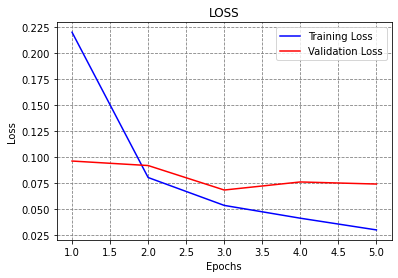

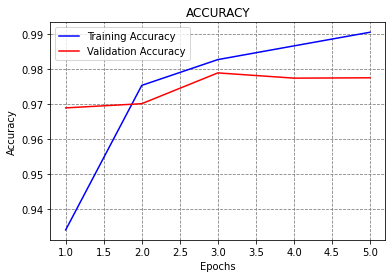

In [ ]:
def plot_history(HISTORY, FIGURE_NAME):
    # Plot the loss and accuracy
    train_loss = HISTORY['loss']
    val_loss = HISTORY['val_loss']
    acc = HISTORY['sparse_categorical_accuracy'] 
    val_acc = HISTORY['val_sparse_categorical_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    fig_name1 = FIGURE_NAME + "_loss.png"
    plt.savefig(fig_name1, bbox_inches='tight', pad_inches=0)

    axes = plt.gca()

    plt.figure()
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    fig_name2 = FIGURE_NAME + "_acc.png"
    plt.savefig(fig_name2, bbox_inches='tight', pad_inches=0)

    plt.show()

# plot the history for the best individual in the initial population
plot_history(history, "p0")

GCGCCCUCGUAAGGAUGAAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCCCCCUGGUCAGGAUGCAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCGCCCUCGUAAGGAUGCAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GUACCCUCGACUGGAUGGAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCUCCCUCGUGCGGAUGCCA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCGCCCUCGUCAGGAUGCAA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCUCCCUCGUCCGGAUCGAA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCACCCUCAGCUGGAUGGAC	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GCCCCCUCGUCAGGAUGCAA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
GUUCCCUCGUCCGGAUCACA	['512', '64', 0, 0, 0, 0.001]	Fitness: 0.9805999994277954
CCGCCCUCGUAAGGAUGCAC	['512', '512', '64', 0, 0, 0.001]	Fitness: 0.9794999957084656
GCGCCUCAGUAAGGAUGAAA	['512', '64', 0, 0, 0, 0.01]	Fitness: 0.9793000221252441
GCUCCCUCGUCCGGACCCAA	['512', '64', '512', 0, 0, 0

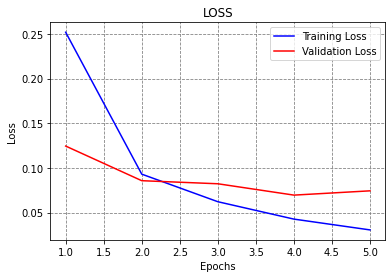

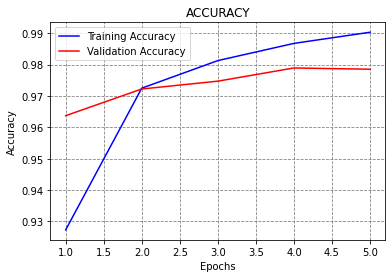

In [ ]:
# do the same thing to the evolved population
pv1 = copy.deepcopy(p1)
pv1 = sort_pop(pv1)
pv1.print()
trait_list = pv1.the_pop[0].trait_list
print(trait_list)
nf = NeuralFitness(trait_list)
nf.get_fitness()
history1 = nf.history.history
# plot the best individual in the evolved population
plot_history(history1, "p1")